In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import timedelta
import matplotlib
import os

root_dir = "../../data/raw/smard/"
filenames = [filenames for dipath, dirname, filenames in os.walk(root_dir)][0]
filenames.sort()
filenames.remove(".DS_Store")
filenames_load = [filename for filename in filenames if "consumption" in filename]
filenames_gen = [filename for filename in filenames if "generation" in filename]
assert len(filenames_load) == len(filenames_gen)
assert len(filenames) == (len(filenames_load) + len(filenames_gen))
print(filenames)
print(filenames_load)
print(filenames_gen)

dfs_load = [pd.read_csv(root_dir + filename, sep=";") for filename in filenames_load]
load_column_names = [filename.split("smard_consumption_")[1].split(".csv")[0] for filename in filenames_load]
print(load_column_names)
dfs_gen = [pd.read_csv(root_dir + filename, sep=";") for filename in filenames_gen]
gen_column_names = [filename.split("smard_generation_")[1].split(".csv")[0] for filename in filenames_gen]
print(gen_column_names)


['smard_consumption_AT.csv', 'smard_consumption_AT_APG.csv', 'smard_consumption_DE.csv', 'smard_consumption_DE_50Hertz.csv', 'smard_consumption_DE_Amprion.csv', 'smard_consumption_DE_TenneT.csv', 'smard_consumption_DE_TransnetBW.csv', 'smard_consumption_LU.csv', 'smard_consumption_LU_Creos.csv', 'smard_generation_AT.csv', 'smard_generation_AT_APG.csv', 'smard_generation_DE.csv', 'smard_generation_DE_50Hertz.csv', 'smard_generation_DE_Amprion.csv', 'smard_generation_DE_TenneT.csv', 'smard_generation_DE_TransnetBW.csv', 'smard_generation_LU.csv', 'smard_generation_LU_Creos.csv']
['smard_consumption_AT.csv', 'smard_consumption_AT_APG.csv', 'smard_consumption_DE.csv', 'smard_consumption_DE_50Hertz.csv', 'smard_consumption_DE_Amprion.csv', 'smard_consumption_DE_TenneT.csv', 'smard_consumption_DE_TransnetBW.csv', 'smard_consumption_LU.csv', 'smard_consumption_LU_Creos.csv']
['smard_generation_AT.csv', 'smard_generation_AT_APG.csv', 'smard_generation_DE.csv', 'smard_generation_DE_50Hertz.csv'

/var/folders/m4/89q121bx0sxd404czvsn99kh0000gn/T/ipykernel_12295/1415256654.py:24: DtypeWarning: Columns (6,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs_gen = [pd.read_csv(root_dir + filename, sep=";") for filename in filenames_gen]
/var/folders/m4/89q121bx0sxd404czvsn99kh0000gn/T/ipykernel_12295/1415256654.py:24: DtypeWarning: Columns (6,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs_gen = [pd.read_csv(root_dir + filename, sep=";") for filename in filenames_gen]
/var/folders/m4/89q121bx0sxd404czvsn99kh0000gn/T/ipykernel_12295/1415256654.py:24: DtypeWarning: Columns (4,13) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs_gen = [pd.read_csv(root_dir + filename, sep=";") for filename in filenames_gen]
/var/folders/m4/89q121bx0sxd404czvsn99kh0000gn/T/ipykernel_12295/1415256654.py:24: DtypeWarning: Columns (3,7,10) have mixed types. Specify dtype option on import or set low_memory

['AT', 'AT_APG', 'DE', 'DE_50Hertz', 'DE_Amprion', 'DE_TenneT', 'DE_TransnetBW', 'LU', 'LU_Creos']


## First look

In [22]:
print(dfs_load[0]["Total (grid load) [MWh] Calculated resolutions"].head())
dfs_load_pp = []
for i, (col_name, df) in enumerate(zip(load_column_names, dfs_load)):
    #print(i)
    df["date"] = pd.to_datetime(df['Date'] + ' ' + df['Start'], format='%b %d, %Y %I:%M %p')
    df = df.drop(columns=["Date", "Start", "End"])
    df = df.rename(columns={"Total (grid load) [MWh] Calculated resolutions": "load"})
    df = df[["date"] + ["load"]]
    df["load"] = df["load"].str.replace(',', '')
    if df["load"].str.contains("-").any():
        print("Dealing with nans in dataset", i)
        df["load"] = df["load"].replace('-', np.nan).astype(float)
        nan_rows = df["load"][df["load"].isna()]
        for j in list(nan_rows.index):
            #print(df.loc[j, "load"])
            #print("replaced")
            df.loc[j, "load"] = (df.loc[j-24, "load"] + df.loc[j+24, "load"]) / 2
            #rint(df.loc[j, "load"])

    df[f"load_{col_name}"] = df["load"].astype(float)
    df = df.drop(columns=["load"])
    if i != 0:
        df = df.drop(columns=["date"])

    dfs_load_pp.append(df)

print(dfs_load_pp[0].head())
load = pd.concat(dfs_load_pp, axis=1)
load

0     6,068.5
1     5,963.5
2    5,726.25
3       5,347
4       5,249
Name: Total (grid load) [MWh] Calculated resolutions, dtype: object
Dealing with nans in dataset 7
Dealing with nans in dataset 8
                 date  load_AT
0 2015-01-01 00:00:00  6068.50
1 2015-01-01 01:00:00  5963.50
2 2015-01-01 02:00:00  5726.25
3 2015-01-01 03:00:00  5347.00
4 2015-01-01 04:00:00  5249.00


,date,load_AT,load_AT_APG,load_DE,load_DE_50Hertz,load_DE_Amprion,load_DE_TenneT,load_DE_TransnetBW,load_LU,load_LU_Creos
0,2015-01-01 00:00:00,6068.50,6068.50,44600.25,9211.50,15245.75,14110.25,5470.00,423.25,423.25
1,2015-01-01 01:00:00,5963.50,5963.50,43454.75,8981.25,15201.50,13267.50,5327.00,403.75,403.75
2,2015-01-01 02:00:00,5726.25,5726.25,41963.25,8782.75,14826.00,12642.00,5087.25,383.25,383.25
3,2015-01-01 03:00:00,5347.00,5347.00,40617.75,8605.50,14405.00,12132.50,4905.50,370.00,370.00
4,2015-01-01 04:00:00,5249.00,5249.00,39936.75,8536.00,14083.25,11840.25,4865.00,363.75,363.75
...,...,...,...,...,...,...,...,...,...,...
78883,2023-12-31 19:00:00,6765.50,6765.50,50254.75,11481.75,17755.75,15318.25,5699.50,500.50,500.50
78884,2023-12-31 20:00:00,6398.75,6398.75,47086.50,10769.50,16645.25,14291.00,5380.75,478.75,478.75
78885,2023-12-31 21:00:00,6057.50,6057.50,45238.50,10260.75,15929.75,13768.00,5280.75,456.25,456.25
78886,2023-12-31 22:00:00,6091.00,6091.00,44099.25,9930.00,15420.00,13459.75,5289.50,454.00,454.00


In [24]:
load.describe() # Caution: Min values of AT and LU are odd!

,date,load_AT,load_AT_APG,load_DE,load_DE_50Hertz,load_DE_Amprion,load_DE_TenneT,load_DE_TransnetBW,load_LU,load_LU_Creos
count,78888,78888.00000,78888.00000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000,78888.000000
mean,2019-07-02 12:05:15.972011008,7040.87557,7040.87557,56360.112254,11816.464659,20559.505853,16989.426598,6975.234424,528.421810,528.421810
min,2015-01-01 00:00:00,663.25000,663.25000,30909.000000,6287.500000,9590.500000,9088.000000,3249.750000,0.000000,0.000000
25%,2017-04-01 18:45:00,5945.00000,5945.00000,48133.375000,10275.500000,17662.250000,14409.187500,5710.500000,453.000000,453.000000
50%,2019-07-02 12:30:00,6993.25000,6993.25000,56045.625000,11871.750000,20447.750000,16837.500000,6878.000000,524.750000,524.750000
75%,2021-10-01 06:15:00,8037.00000,8037.00000,64691.625000,13280.000000,23548.250000,19565.312500,8253.500000,603.000000,603.000000
max,2023-12-31 23:00:00,10802.75000,10802.75000,81077.500000,18106.000000,32060.000000,24853.500000,10845.000000,843.250000,843.250000
std,NaN,1366.17161,1366.17161,10000.237611,1944.401277,3617.131395,3146.330621,1503.801276,110.575783,110.575783


In [26]:
load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78888 entries, 0 to 78887
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                78888 non-null  datetime64[ns]
 1   load_AT             78888 non-null  float64       
 2   load_AT_APG         78888 non-null  float64       
 3   load_DE             78888 non-null  float64       
 4   load_DE_50Hertz     78888 non-null  float64       
 5   load_DE_Amprion     78888 non-null  float64       
 6   load_DE_TenneT      78888 non-null  float64       
 7   load_DE_TransnetBW  78888 non-null  float64       
 8   load_LU             78888 non-null  float64       
 9   load_LU_Creos       78888 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 6.0 MB


## df2

In [ ]:
df2["date"] = pd.to_datetime(df2['Date'] + ' ' + df2['Start'], format='%b %d, %Y %I:%M %p')
df2 = df2.drop(columns=["Date", "Start", "End"])
df2["wind_gen"] = df2["Wind offshore [MWh] Calculated resolutions"].str.replace(',', '').astype(float) + df2["Wind onshore [MWh] Calculated resolutions"].str.replace(',', '').astype(float)
df2 = df2.rename(columns={"Photovoltaics [MWh] Calculated resolutions": "solar_gen", "Hydro pumped storage [MWh] Calculated resolutions": "hydro_storage_gen"})
df2 = df2[["date", "wind_gen", "solar_gen"]]
df2["solar_gen"] = df2["solar_gen"].str.replace(',', '').astype(float)

In [ ]:
print(dfs_gen[0][].head())
dfs_load_pp = ["Wind onshore [MWh] Calculated resolutions"]
for i, (col_name, df) in enumerate(zip(load_column_names, dfs_load)):
    #print(i)
    df["date"] = pd.to_datetime(df['Date'] + ' ' + df['Start'], format='%b %d, %Y %I:%M %p')
    df = df.drop(columns=["Date", "Start", "End"])
    df = df.rename(columns={"Total (grid load) [MWh] Calculated resolutions": "load"})
    df = df[["date"] + ["load"]]
    df["load"] = df["load"].str.replace(',', '')
    if df["load"].str.contains("-").any():
        print("Dealing with nans in dataset", i)
        df["load"] = df["load"].replace('-', np.nan).astype(float)
        nan_rows = df["load"][df["load"].isna()]
        for j in list(nan_rows.index):
            #print(df.loc[j, "load"])
            #print("replaced")
            df.loc[j, "load"] = (df.loc[j-24, "load"] + df.loc[j+24, "load"]) / 2
            #rint(df.loc[j, "load"])

    df[f"load_{col_name}"] = df["load"].astype(float)
    df = df.drop(columns=["load"])
    if i != 0:
        df = df.drop(columns=["date"])

    dfs_load_pp.append(df)

print(dfs_load_pp[0].head())
load = pd.concat(dfs_load_pp, axis=1)
load

In [23]:
df2.describe()

NameError: name 'df2' is not defined

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78888 entries, 0 to 78887
Data columns (total 15 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Date                                               78888 non-null  object 
 1   Start                                              78888 non-null  object 
 2   End                                                78888 non-null  object 
 3   Biomass [MWh] Calculated resolutions               78888 non-null  object 
 4   Hydropower [MWh] Calculated resolutions            78888 non-null  object 
 5   Wind offshore [MWh] Calculated resolutions         78888 non-null  object 
 6   Wind onshore [MWh] Calculated resolutions          78888 non-null  object 
 7   Photovoltaics [MWh] Calculated resolutions         78888 non-null  object 
 8   Other renewable [MWh] Calculated resolutions       78888 non-null  float64
 9   Nuclea

In [ ]:
df2.head()

,Date,Start,End,Biomass [MWh] Calculated resolutions,Hydropower [MWh] Calculated resolutions,Wind offshore [MWh] Calculated resolutions,Wind onshore [MWh] Calculated resolutions,Photovoltaics [MWh] Calculated resolutions,Other renewable [MWh] Calculated resolutions,Nuclear [MWh] Calculated resolutions,Lignite [MWh] Calculated resolutions,Hard coal [MWh] Calculated resolutions,Fossil gas [MWh] Calculated resolutions,Hydro pumped storage [MWh] Calculated resolutions,Other conventional [MWh] Calculated resolutions
0,"Jan 1, 2015",12:00 AM,1:00 AM,"4,024.25","1,158.25",516.5,"8,128",0,133.0,"10,710.5","15,687.25","3,219.75","1,226.25","1,525.75","4,909.25"
1,"Jan 1, 2015",1:00 AM,2:00 AM,"3,982.75","1,188",516.25,"8,297.5",0,122.5,"11,086.25","15,321.75","2,351.25",870.75,"1,079.25","4,932.75"
2,"Jan 1, 2015",2:00 AM,3:00 AM,"4,019.5","1,139.25",514,"8,540",0,93.0,"11,026.25","14,817.5","2,227",809.5,787,"5,041.75"
3,"Jan 1, 2015",3:00 AM,4:00 AM,"4,040.75","1,122.5",517.75,"8,552",0,86.5,"11,027.75","14,075","2,339.75",821,287.75,"5,084"
4,"Jan 1, 2015",4:00 AM,5:00 AM,"4,037.75","1,112",519.75,"8,643.5",0,86.5,"10,962.25","14,115","2,461.5",831.25,346.75,"5,070.75"


In [ ]:
df2["date"] = pd.to_datetime(df2['Date'] + ' ' + df2['Start'], format='%b %d, %Y %I:%M %p')
df2 = df2.drop(columns=["Date", "Start", "End"])
df2["wind_gen"] = df2["Wind offshore [MWh] Calculated resolutions"].str.replace(',', '').astype(float) + df2["Wind onshore [MWh] Calculated resolutions"].str.replace(',', '').astype(float)
df2 = df2.rename(columns={"Photovoltaics [MWh] Calculated resolutions": "solar_gen", "Hydro pumped storage [MWh] Calculated resolutions": "hydro_storage_gen"})
df2 = df2[["date", "wind_gen", "solar_gen"]]
df2["solar_gen"] = df2["solar_gen"].str.replace(',', '').astype(float)
#df2["hydro_storage_gen"] = df2["hydro_storage_gen"].str.replace(',', '').astype(float)

In [ ]:
df2 = df2.drop(columns=("date"))
df = pd.concat((df1, df2), axis=1)

#Convert to UTC time
df['date'] = df['date'].dt.tz_localize('Europe/Berlin', ambiguous='infer').dt.tz_convert('UTC')

# Convert to permanent utc+1 which is cet winter time.
df['date'] =  df['date'] + timedelta(hours=1) 
df


,date,load,wind_gen,solar_gen
0,2015-01-01 00:00:00+00:00,44600.25,8644.50,0.0
1,2015-01-01 01:00:00+00:00,43454.75,8813.75,0.0
2,2015-01-01 02:00:00+00:00,41963.25,9054.00,0.0
3,2015-01-01 03:00:00+00:00,40617.75,9069.75,0.0
4,2015-01-01 04:00:00+00:00,39936.75,9163.25,0.0
...,...,...,...,...
78883,2023-12-31 19:00:00+00:00,48792.75,35267.00,0.0
78884,2023-12-31 20:00:00+00:00,45698.50,36010.00,0.0
78885,2023-12-31 21:00:00+00:00,43818.00,35827.75,0.0
78886,2023-12-31 22:00:00+00:00,42893.50,35882.25,0.0


In [ ]:
df.to_csv("./../../data/preproc/smard_data.csv", index=False)
df.describe()
#494 TWh pro Jahr

,load,wind_gen,solar_gen
count,78888.000000,78888.000000,78888.000000
mean,56350.076875,12685.801804,4961.652653
std,10002.022918,9862.947669,7743.748810
min,30909.000000,81.500000,0.000000
25%,48122.625000,4914.437500,0.000000
50%,56035.875000,9893.125000,147.500000
75%,64684.000000,18139.062500,7768.875000
max,81077.500000,52856.250000,40673.750000


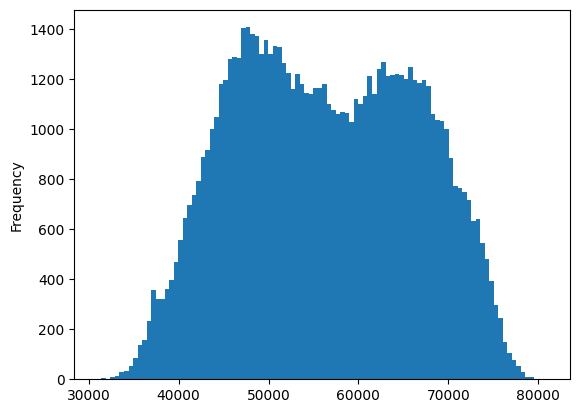

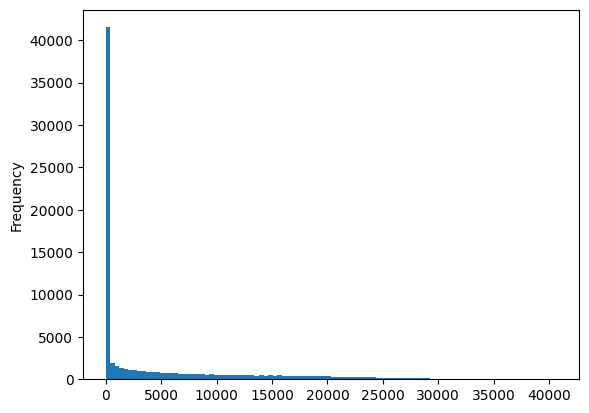

<Axes: ylabel='Frequency'>

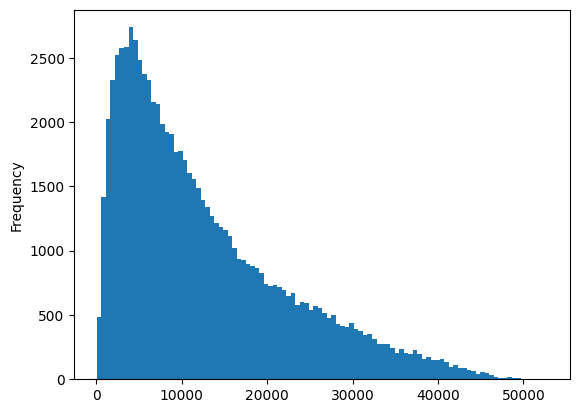

In [ ]:
import matplotlib.pyplot as plt

df['load'].plot.hist(bins=100)
plt.show()
df['solar_gen'].plot.hist(bins=100)
plt.show()
df['wind_gen'].plot.hist(bins=100)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78888 entries, 0 to 78887
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   date       78888 non-null  datetime64[ns, UTC]
 1   load       78888 non-null  float64            
 2   wind_gen   78888 non-null  float64            
 3   solar_gen  78888 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(3)
memory usage: 2.4 MB


In [ ]:
df_cropped = df[49000:50000]
df_cropped.head(30)

,date,load,wind_gen,solar_gen
49000,2020-08-03 16:00:00+00:00,57065.25,4174.50,7724.00
49001,2020-08-03 17:00:00+00:00,56857.75,4423.00,4793.75
49002,2020-08-03 18:00:00+00:00,56067.50,4197.50,2187.75
49003,2020-08-03 19:00:00+00:00,54212.00,3678.75,421.25
49004,2020-08-03 20:00:00+00:00,52430.50,3884.00,3.25
49005,2020-08-03 21:00:00+00:00,49200.50,4286.25,0.00
49006,2020-08-03 22:00:00+00:00,44933.25,4304.25,0.00
49007,2020-08-03 23:00:00+00:00,42203.75,4240.00,0.00
49008,2020-08-04 00:00:00+00:00,40838.00,4689.50,0.00
49009,2020-08-04 01:00:00+00:00,39984.00,4953.25,0.00


['load', 'wind_gen', 'solar_gen']


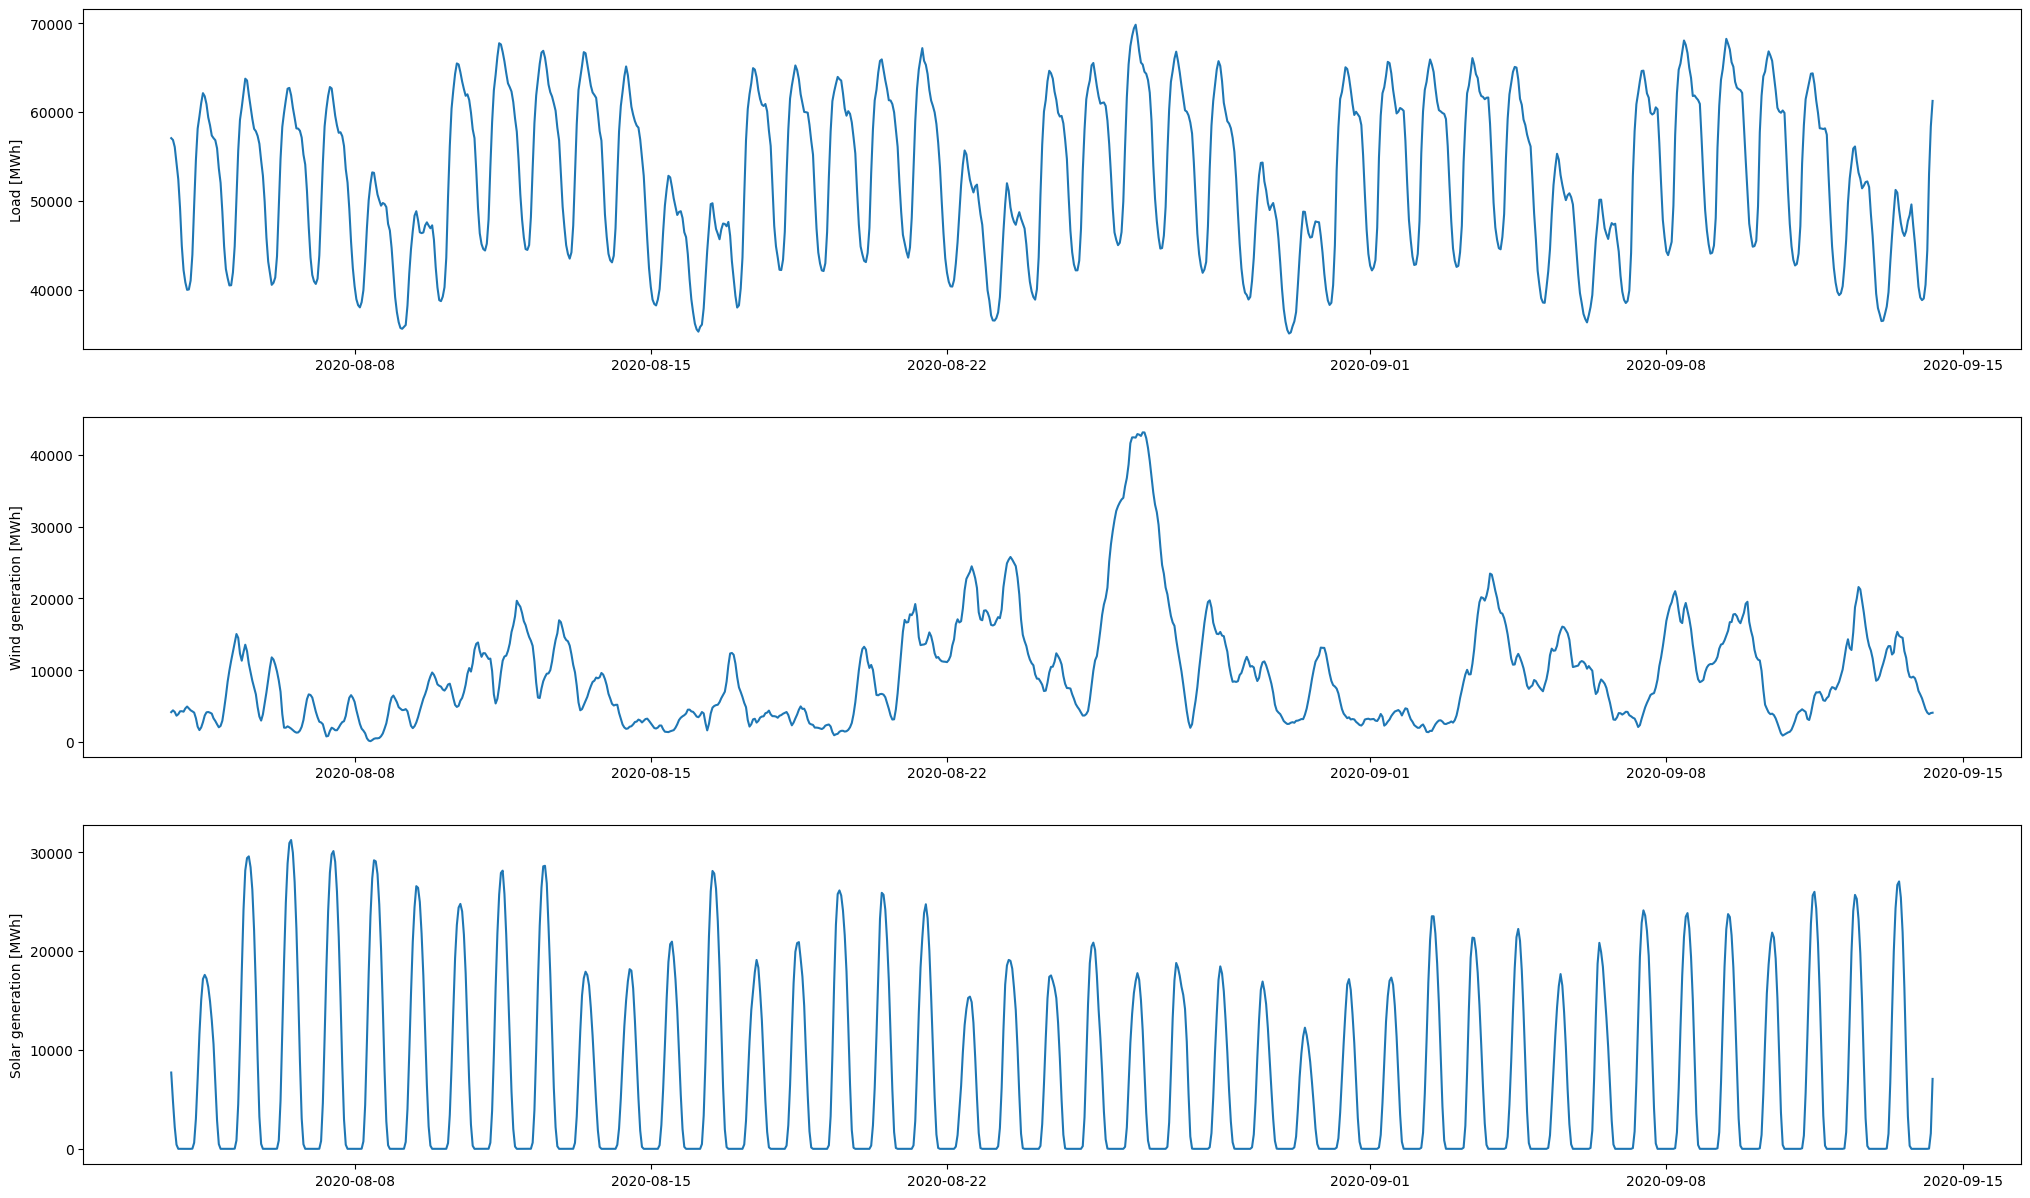

In [ ]:
# plot different time series
skip_days = 14
skip_hours = 24*skip_days

keys = list(df.drop(columns="date").columns)
print(keys)
labels = keys
axis_labels = ["Load [MWh]", "Wind generation [MWh]", "Solar generation [MWh]"]

fig, axs = plt.subplots(3,1, figsize=(25,15), dpi=100)

for i, (key, label) in enumerate(zip(keys, labels)):
    axs[i].plot(df_cropped['date'], df_cropped[key], label=label)
    #axs[i].set_xticks(np.array(list(df_cropped['date']))[::skip_hours])
    #axs[i].legend()
    font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 22}

    matplotlib.rc('font', **font)
    #axs[i].set_xlabel("Time")
    axs[i].set_ylabel(axis_labels[i])
#font = {'family' : 'arial',
        #'weight' : 'bold',
        #'size'   : 22}

matplotlib.rc('font', **font)
plt.show()

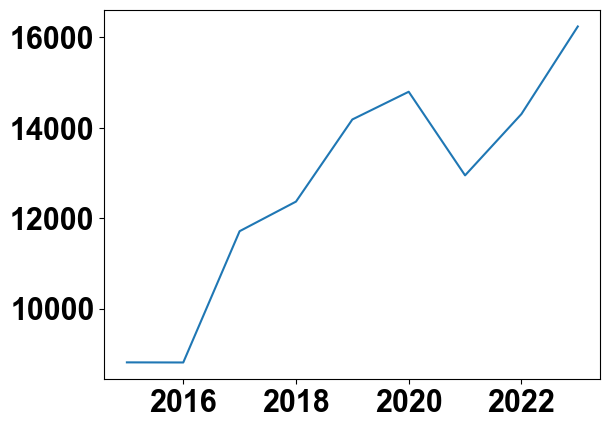

In [ ]:
# plot 
means = df["wind_gen"].groupby(df["date"].dt.year).mean()
plt.plot(means)

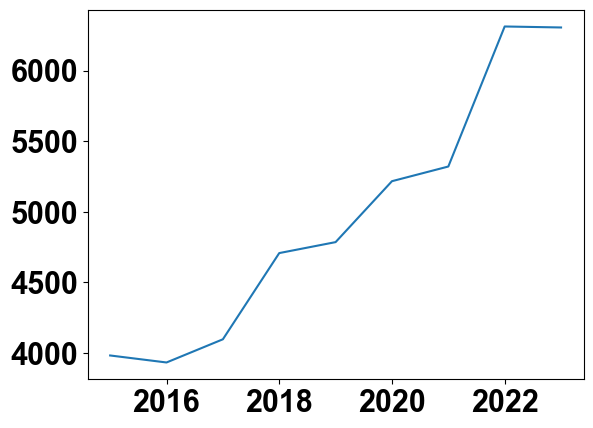

In [ ]:
# plot
means = df["solar_gen"].groupby(df["date"].dt.year).mean()
plt.plot(means)

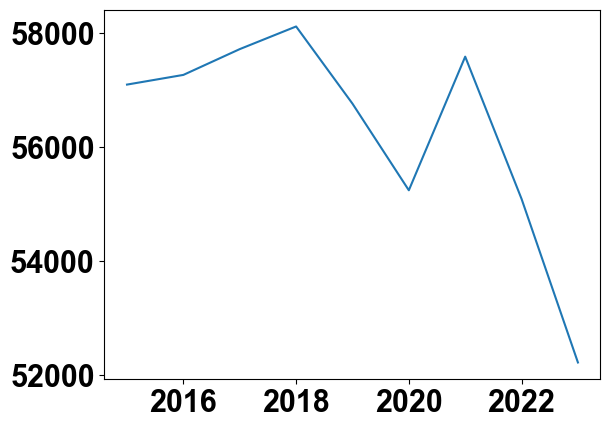

In [ ]:
means = df["load"].groupby(df["date"].dt.year).mean()
plt.plot(means)

In [ ]:
#means = df["hydro_storage_gen"].groupby(df["date"].dt.year).mean()
#plt.plot(means)

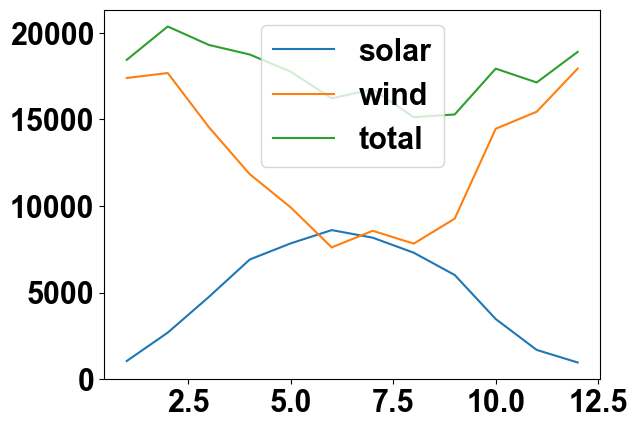

In [ ]:
# plot
means_solar = df["solar_gen"].groupby(df["date"].dt.month).mean()
means_wind = df["wind_gen"].groupby(df["date"].dt.month).mean()

plt.plot(means_solar, label="solar")
plt.plot(means_wind, label="wind")
plt.plot(means_solar+means_wind, label="total")
plt.legend()

# Dunkelflaute in autumn (less sun but not yet a lot of wind)

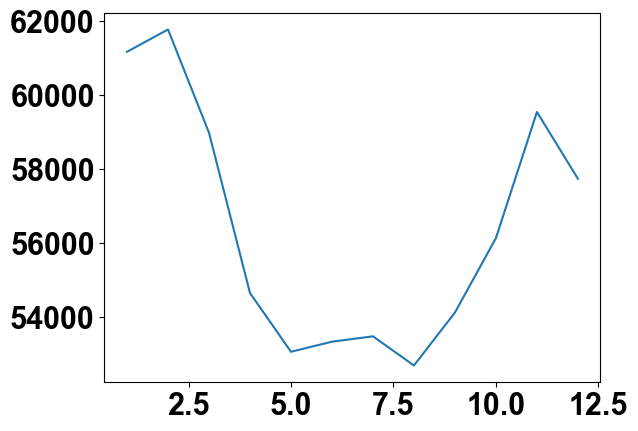

In [ ]:
means_load = df["load"].groupby(df["date"].dt.month).mean()
plt.plot(means_load, label="load")

In [ ]:
#means = df["hydro_storage_gen"].groupby(df["date"].dt.month).mean()
#plt.plot(means)

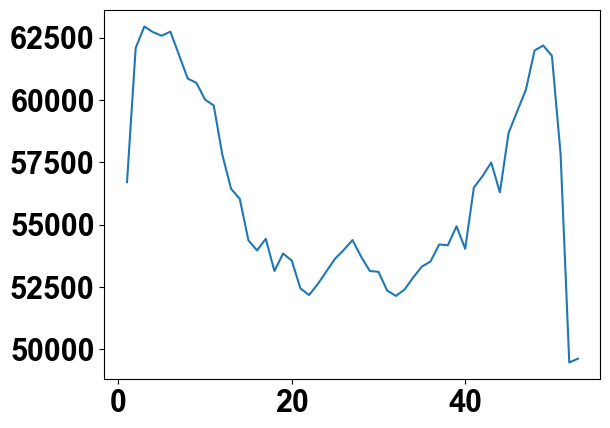

In [ ]:
means_load = df["load"].groupby(df["date"].dt.isocalendar().week).mean()
plt.plot(means_load, label="load")

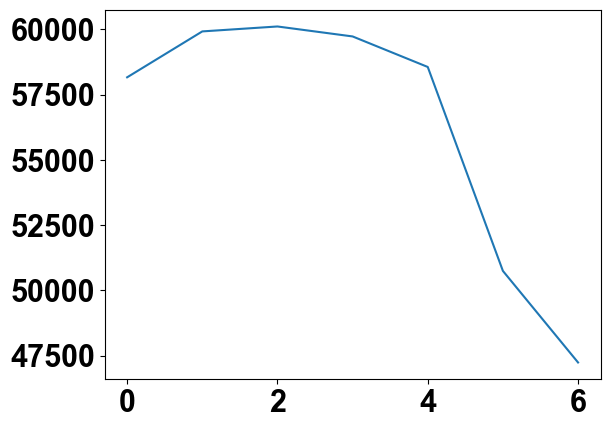

In [ ]:
means_load = df["load"].groupby(df["date"].dt.dayofweek).mean()
plt.plot(means_load, label="load")

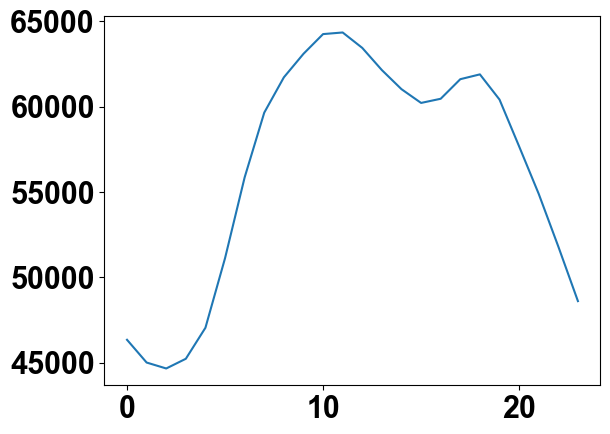

In [ ]:
means_load = df["load"].groupby(df["date"].dt.hour).mean()
plt.plot(means_load, label="load")